In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
consDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-consDF.pqt")
consDF = consDF.drop(columns = ["credit_score"])
consDF = consDF.dropna()
acctDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt")
trxnDF = pd.read_parquet("/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt")
catmap = pd.read_csv("/uss/hdsi-prismdata/q2-ucsd-cat-map.csv")
acctDF = acctDF[acctDF["prism_consumer_id"].isin(consDF['prism_consumer_id'])]
acctDF["balance_date"] = pd.to_datetime(acctDF["balance_date"])
trxnDF = trxnDF[trxnDF["prism_consumer_id"].isin(consDF['prism_consumer_id'])]
trxnDF = trxnDF.drop_duplicates()
trxnDF["posted_date"] = pd.to_datetime(trxnDF["posted_date"])

### Haris

In [4]:
def category_feats(trxnDF):
    neg_cats = [25, 10, 46, 23]
    neg_trxns = trxnDF[trxnDF['category'].isin(neg_cats)].copy()
    monthly_neg_count = neg_trxns.groupby(['prism_consumer_id', neg_trxns['posted_date'].dt.to_period('M')])['amount'].count().reset_index()
    avg_monthly_neg_count = monthly_neg_count.groupby('prism_consumer_id')['amount'].mean().rename('avg_monthly_neg_count')
    total_neg_amount = neg_trxns.groupby('prism_consumer_id')['amount'].sum().rename('total_neg_amount')
    has_neg = neg_trxns.groupby('prism_consumer_id')['amount'].any().astype(int).rename('has_neg')
    return pd.concat([avg_monthly_neg_count, total_neg_amount, has_neg], axis=1).reset_index()

In [5]:
def balance_feats(acctDF):
    avg_balance = acctDF.groupby('prism_consumer_id')['balance'].mean().rename('avg_balance')
    features = avg_balance
    return avg_balance

In [6]:
def income_feats(trxnDF): 
    income_cats = [2, 3, 7, 8, 9, 49]
    income_trxns = trxnDF[trxnDF['category'].isin(income_cats)].copy()
    income_trxns['posted_date'] = pd.to_datetime(income_trxns['posted_date'])
    monthly_income = income_trxns.groupby(
        ['prism_consumer_id', income_trxns['posted_date'].dt.to_period('M')])['amount'].sum()
    avg_monthly_income = monthly_income.groupby('prism_consumer_id').mean().rename('avg_monthly_income')
    income_std = monthly_income.groupby('prism_consumer_id').std().rename('income_std')
    features = pd.concat([avg_monthly_income, income_std], axis=1).reset_index()
    return features

In [65]:
cat_haris = category_feats(trxnDF)
bal_haris = balance_feats(acctDF)
inc_haris = income_feats(trxnDF)
haris_feats = (
    cat_haris
        .merge(bal_haris, on="prism_consumer_id", how="left")
        .merge(inc_haris, on="prism_consumer_id", how="left")
)
haris_feats

,prism_consumer_id,avg_monthly_neg_count,total_neg_amount,has_neg,avg_balance,avg_monthly_income,income_std
0,10,2.000000,166.00,1,412.120,2202.962857,958.152740
1,10001,1.000000,312.10,1,2432.950,5252.063750,3380.524096
2,10002,1.857143,64.35,1,NaN,2773.355000,1571.124422
3,10004,1.000000,36.00,1,NaN,531.040000,447.318614
4,10005,1.000000,30.00,1,3436.500,5361.850000,2394.892889
...,...,...,...,...,...,...,...
6319,99,1.000000,25.00,1,9275.140,15425.347143,24367.614621
6320,996,1.000000,303.00,1,0.000,2053.605000,2836.622492
6321,997,1.000000,747.49,1,33448.175,4828.208571,2449.197166
6322,998,3.500000,958.50,1,3447.185,5544.717143,2551.244732


### Brighton

In [8]:
# Balance DF

def compute_first_snapshot(acctDF):
    acct_consumer = (
        acctDF
        .groupby(["prism_consumer_id", "balance_date"], as_index=False)["balance"]
        .sum()
    )

    first_snapshot = (
        acct_consumer
        .sort_values("balance_date")
        .groupby("prism_consumer_id", as_index=False)
        .first()
        .rename(columns={
            "balance_date": "start_date",
            "balance": "start_balance"
        })
    )

    return first_snapshot


# ======================
# Prepare transactions
# ======================
def prepare_transactions(trxnDF):
    trxnDF = trxnDF.copy()
    trxnDF["signed_amount"] = trxnDF["amount"].where(
        trxnDF["credit_or_debit"] == "CREDIT",
        -trxnDF["amount"]
    )
    return trxnDF


# ======================
# Forward balances
# ======================
def compute_forward_balances(trxnDF, first_snapshot):
    trxn_with_start = trxnDF.merge(
        first_snapshot,
        on="prism_consumer_id",
        how="inner"
    )

    trxn_with_start = trxn_with_start[
        trxn_with_start["posted_date"] >= trxn_with_start["start_date"]
    ].sort_values(["prism_consumer_id", "posted_date"])

    trxn_with_start["cum_trxn"] = (
        trxn_with_start
        .groupby("prism_consumer_id")["signed_amount"]
        .cumsum()
    )

    trxn_with_start["running_balance"] = (
        trxn_with_start["start_balance"] + trxn_with_start["cum_trxn"]
    )

    start_rows = first_snapshot.rename(columns={
        "start_date": "posted_date",
        "start_balance": "running_balance"
    })
    start_rows["signed_amount"] = 0.0

    cols = [
    "prism_consumer_id",
    "posted_date",
    "signed_amount",
    "running_balance",
    "category",
    "credit_or_debit"
    ]

    start_rows = start_rows.reindex(columns=cols)
    trxn_with_start = trxn_with_start.reindex(columns=cols)


    forward_df = pd.concat([
        start_rows[["prism_consumer_id", "posted_date", "signed_amount", "running_balance", "category",
    "credit_or_debit"]],
        trxn_with_start[["prism_consumer_id", "posted_date", "signed_amount", "running_balance", "category",
    "credit_or_debit"]],
    ]).sort_values(["prism_consumer_id", "posted_date"])

    return forward_df, trxn_with_start


# ======================
# Backward balances
# ======================
def compute_backward_balances(trxnDF, first_snapshot):
    trxn_before = trxnDF.merge(
        first_snapshot,
        on="prism_consumer_id",
        how="inner"
    )

    trxn_before = trxn_before[
        trxn_before["posted_date"] < trxn_before["start_date"]
    ].sort_values(
        ["prism_consumer_id", "posted_date"],
        ascending=[True, False]
    )

    trxn_before["cum_trxn_back"] = (
        trxn_before
        .groupby("prism_consumer_id")["signed_amount"]
        .cumsum()
    )

    trxn_before["running_balance"] = (
        trxn_before["start_balance"] - trxn_before["cum_trxn_back"]
    )

    start_rows_back = first_snapshot.rename(columns={
        "start_date": "posted_date",
        "start_balance": "running_balance"
    })
    start_rows_back["signed_amount"] = 0.0
    cols = [
    "prism_consumer_id",
    "posted_date",
    "signed_amount",
    "running_balance",
    "category",
    "credit_or_debit"
    ]
    start_rows_back = start_rows_back.reindex(columns=cols)
    trxn_before = trxn_before.reindex(columns=cols)
    
    backward_df = pd.concat([
        trxn_before[["prism_consumer_id", "posted_date", "signed_amount", "running_balance", "category",
    "credit_or_debit"]],
        start_rows_back[["prism_consumer_id", "posted_date", "signed_amount", "running_balance", "category",
    "credit_or_debit"]],
    ]).sort_values(["prism_consumer_id", "posted_date"])

    return backward_df, trxn_before


# ======================
# Full balance history
# ======================
def build_full_balance_df(trxn_before, trxn_with_start, first_snapshot):
    snapshot_row = first_snapshot.rename(columns={
        "start_date": "posted_date",
        "start_balance": "running_balance"
    })
    snapshot_row["signed_amount"] = 0.0
    cols = [
    "prism_consumer_id",
    "posted_date",
    "signed_amount",
    "running_balance",
    "category",
    "credit_or_debit"
    ]
    snapshot_row = snapshot_row.reindex(columns=cols)
    full_balance_df = (
        pd.concat([
            trxn_before[["prism_consumer_id", "posted_date", "signed_amount", "running_balance", "category",
    "credit_or_debit"]],
            snapshot_row[["prism_consumer_id", "posted_date", "signed_amount", "running_balance", "category",
    "credit_or_debit"]],
            trxn_with_start[["prism_consumer_id", "posted_date", "signed_amount", "running_balance", "category",
    "credit_or_debit"]],
        ])
        .sort_values(["prism_consumer_id", "posted_date"])
        .reset_index(drop=True)
    )

    return full_balance_df

In [9]:
def build_account_features(acctDF):
    agg_bal = (
        acctDF
        .groupby("prism_consumer_id", as_index=False)
        .agg(
            total_balance=("balance", "sum"),
            avg_balance=("balance", "mean"),
            max_balance=("balance", "max"),
            min_balance=("balance", "min"),
            std_balance=("balance", "std"),
            num_accounts=("balance", "count"),
        )
    )

    pivot_bal = (
        acctDF
        .pivot_table(
            index="prism_consumer_id",
            columns="account_type",
            values="balance",
            aggfunc="sum",
            fill_value=0
        )
        .reset_index()
    )

    pivot_bal["checking_to_savings_ratio"] = (
        pivot_bal.get("CHECKING", 0) / (pivot_bal.get("SAVINGS", 0) + 1)
    )
    pivot_bal["has_savings_account"] = (
        pivot_bal.get("SAVINGS", 0) > 0
    ).astype(int)

    pivot_bal = pivot_bal[
        [
            "prism_consumer_id",
            "CHECKING",
            "SAVINGS",
            "checking_to_savings_ratio",
            "has_savings_account",
        ]
    ]

    acctDF["liquid_balance"] = (
        acctDF
        .assign(
            liquid_component=lambda df: np.where(
                df["account_type"].isin(["CHECKING", "SAVINGS"]),
                df["balance"],
                0
            )
        )
        .groupby("prism_consumer_id")["liquid_component"]
        .transform("sum")
    )

    liquidity_flags = (
        acctDF
        .groupby("prism_consumer_id", as_index=False)["liquid_balance"]
        .first()
    )
    liquidity_flags["low_liquidity"] = (liquidity_flags["liquid_balance"] < 500).astype(int)
    liquidity_flags["is_liquid"] = (liquidity_flags["liquid_balance"] > 0).astype(int)

    account_features = (
        agg_bal
        .merge(pivot_bal, on="prism_consumer_id", how="left")
        .merge(liquidity_flags, on="prism_consumer_id", how="left")
    )

    return account_features

In [10]:
def build_balance_dynamics(full_balance_df):
    full_balance_df = full_balance_df.sort_values(
        ["prism_consumer_id", "posted_date"]
    )

    full_balance_df["daily_balance_change"] = (
        full_balance_df
        .groupby("prism_consumer_id")["running_balance"]
        .diff()
    )

    daily_change_features = (
        full_balance_df
        .groupby("prism_consumer_id", as_index=False)
        .agg(
            mean_daily_change=("daily_balance_change", "mean"),
            std_daily_change=("daily_balance_change", "std"),
            max_daily_drop=("daily_balance_change", "min"),
            max_daily_increase=("daily_balance_change", "max"),
        )
    )

    latest_dates = (
        full_balance_df
        .groupby("prism_consumer_id")["posted_date"]
        .max()
        .reset_index(name="latest_date")
    )

    full_balance_df = full_balance_df.merge(latest_dates, on="prism_consumer_id")
    full_balance_df["date_30d"] = full_balance_df["latest_date"] - pd.Timedelta(days=30)
    full_balance_df["date_90d"] = full_balance_df["latest_date"] - pd.Timedelta(days=90)
    full_balance_df["date_365d"] = full_balance_df["latest_date"] - pd.Timedelta(days=365)

    def last_balance_before(df, date_col):
        return (
            df[df["posted_date"] <= df[date_col]]
            .groupby("prism_consumer_id")["running_balance"]
            .last()
        )

    ending_balance = (
        full_balance_df
        .groupby("prism_consumer_id")["running_balance"]
        .last()
    )

    recent_balance_features = pd.DataFrame({
        "recent_30d_balance_change": ending_balance - last_balance_before(full_balance_df, "date_30d"),
        "recent_90d_balance_change": ending_balance - last_balance_before(full_balance_df, "date_90d"),
    }).fillna(0).reset_index()

    mean_balance_features = (
        pd.concat(
            [
                full_balance_df[full_balance_df["posted_date"] >= full_balance_df["date_30d"]]
                .groupby("prism_consumer_id")["running_balance"]
                .mean()
                .rename("mean_balance_30d"),

                full_balance_df[full_balance_df["posted_date"] >= full_balance_df["date_90d"]]
                .groupby("prism_consumer_id")["running_balance"]
                .mean()
                .rename("mean_balance_90d"),

                full_balance_df[full_balance_df["posted_date"] >= full_balance_df["date_365d"]]
                .groupby("prism_consumer_id")["running_balance"]
                .mean()
                .rename("mean_balance_365d"),
            ],
            axis=1
        )
        .reset_index()
    )

    balance_dynamics_features = (
        daily_change_features
        .merge(recent_balance_features, on="prism_consumer_id", how="left")
        .merge(mean_balance_features, on="prism_consumer_id", how="left")
    )

    return balance_dynamics_features

In [11]:
def build_income_features(trxnDF, catmap):
    trxnDF = trxnDF.merge(
        catmap,
        left_on="category",
        right_on="category_id",
        how="left"
    )

    INCOME_CATEGORIES = [
        "DEPOSIT",
        "PAYCHECK",
        "PAYCHECK_PLACEHOLDER",
        "INVESTMENT_INCOME",
        "OTHER_BENEFITS",
        "UNEMPLOYMENT_BENEFITS",
        "PENSION",
    ]

    income_txn = trxnDF[
        (trxnDF["credit_or_debit"] == "CREDIT") &
        (trxnDF["category_y"].isin(INCOME_CATEGORIES))
    ].copy()

    income_txn["month"] = income_txn["posted_date"].dt.to_period("M")

    total_income = (
        income_txn
        .groupby("prism_consumer_id", as_index=False)["amount"]
        .sum()
        .rename(columns={"amount": "total_income"})
    )

    avg_monthly_income = (
        income_txn
        .groupby(["prism_consumer_id", "month"])["amount"]
        .sum()
        .groupby("prism_consumer_id")
        .mean()
        .reset_index(name="avg_monthly_income")
    )

    income_consistency = (
        income_txn
        .groupby("prism_consumer_id")["month"]
        .nunique()
        .reset_index(name="num_income_months")
    )

    income_sources = (
        income_txn
        .groupby("prism_consumer_id")["category_y"]
        .nunique()
        .reset_index(name="num_income_sources")
    )

    benefits_flag = (
        income_txn[income_txn["category_x"].isin([8, 9, 49])]
        .groupby("prism_consumer_id")
        .size()
        .reset_index(name="benefits_txn_count")
    )
    benefits_flag["has_benefits_income"] = (
        benefits_flag["benefits_txn_count"] > 0
    ).astype(int)

    income_features = (
        total_income
        .merge(avg_monthly_income, on="prism_consumer_id", how="left")
        .merge(income_consistency, on="prism_consumer_id", how="left")
        .merge(income_sources, on="prism_consumer_id", how="left")
    )

    return income_features

In [66]:
first_snapshot = compute_first_snapshot(acctDF)
trxnDF = prepare_transactions(trxnDF)
forward_df, trxn_with_start = compute_forward_balances(trxnDF, first_snapshot)
backward_df, trxn_before = compute_backward_balances(trxnDF, first_snapshot)
full_balance_df = build_full_balance_df(trxn_before, trxn_with_start, first_snapshot)
acc_brighton = build_account_features(acctDF)
bal_brighton = build_balance_dynamics(full_balance_df)
inc_brighton = build_income_features(trxnDF, catmap) 
brighton_feats = (
    acc_brighton
        .merge(bal_brighton, on="prism_consumer_id", how="left")
        .merge(inc_brighton, on="prism_consumer_id", how="left")
)
brighton_feats

,prism_consumer_id,total_balance,avg_balance,max_balance,min_balance,std_balance,num_accounts,CHECKING,SAVINGS,checking_to_savings_ratio,...,max_daily_increase,recent_30d_balance_change,recent_90d_balance_change,mean_balance_30d,mean_balance_90d,mean_balance_365d,total_income,avg_monthly_income,num_income_months,num_income_sources
0,0,320.37,160.185,294.67,25.70,190.190511,2,294.67,25.70,11.036330,...,1600.43,547.55,-607.44,572.755059,488.715527,1197.568484,9320.56,1331.508571,7.0,2.0
1,1,3302.42,1651.210,3211.18,91.24,2206.130731,2,91.24,3211.18,0.028404,...,1390.85,-909.81,489.64,3106.989565,2893.585143,1968.212984,13411.59,1915.941429,7.0,2.0
2,10,824.24,412.120,822.75,1.49,580.718515,2,822.75,1.49,330.421687,...,1314.94,693.62,287.69,729.500667,713.703275,955.025789,15420.74,2202.962857,7.0,2.0
3,100,2655.47,1327.735,1853.07,802.40,742.935882,2,802.40,1853.07,0.432778,...,2780.00,132.93,12.29,-3692.327647,-4073.049310,-2946.220328,24411.78,4068.630000,6.0,1.0
4,1000,95.25,47.625,95.23,0.02,67.323637,2,95.23,0.02,93.362745,...,10000.00,-118.10,-233.32,1344.578421,632.280000,495.667547,48378.60,6911.228571,7.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10403,995,95836.07,47918.035,80136.87,15699.20,45564.313421,2,15699.20,80136.87,0.195902,...,3386.84,4088.74,2636.44,94576.679355,94704.844805,89883.466490,36558.09,5222.584286,7.0,2.0
10404,996,0.00,0.000,0.00,0.00,0.000000,2,0.00,0.00,0.000000,...,45161.78,3542.20,-10023.38,-12424.948673,-8528.695333,-20919.496076,4107.21,2053.605000,2.0,2.0
10405,997,66896.35,33448.175,60592.48,6303.87,38387.844272,2,60592.48,6303.87,9.610425,...,5428.68,-1962.52,-4680.05,63111.350897,63640.739211,66327.925578,33797.46,4828.208571,7.0,2.0
10406,998,6894.37,3447.185,6080.39,813.98,3723.914224,2,813.98,6080.39,0.133848,...,6472.43,-850.27,5122.36,6790.230616,4153.789499,2563.110665,38813.02,5544.717143,7.0,2.0


### Kyle

In [13]:
from scipy.fft import fft, fftfreq

INCOME_CATEGORIES = [3, 7, 8, 9, 48, 49] 

def get_stability_features(group):
    """
    Calculates Fourier-based stability and frequency for a user's transaction signal.
    """
    daily = group.set_index('posted_date')['signed_amount'].resample('D').sum().fillna(0)
    signal = daily.values
    n = len(signal)
    
    if n < 14: 
        return pd.Series({'freq': 0, 'stability': 0})
        
    f_transform = np.abs(fft(signal))
    freqs = fftfreq(n, d=1)
    
    pos_mask = freqs > 0
    if not any(pos_mask): 
        return pd.Series({'freq': 0, 'stability': 0})
        
    magnitudes = f_transform[pos_mask]
    dominant_idx = np.argmax(magnitudes)
    
    return pd.Series({
        'freq': freqs[pos_mask][dominant_idx], 
        'stability': magnitudes[dominant_idx] / np.sum(magnitudes)
    })

def create_features(consDF, full_balance_df):
    """
    Processes raw dataframes into a final feature set for modeling.
    """
    A_inc = full_balance_df[full_balance_df["category"].isin(INCOME_CATEGORIES)].copy()
    A_inc['posted_date'] = pd.to_datetime(A_inc['posted_date'])

    A_exp = full_balance_df[full_balance_df["signed_amount"] < 0].copy()
    A_exp['posted_date'] = pd.to_datetime(A_exp['posted_date'])

    inc_stab = A_inc.groupby("prism_consumer_id").apply(get_stability_features).reset_index()
    exp_stab = A_exp.groupby("prism_consumer_id").apply(get_stability_features).reset_index()

    inc_meanie = A_inc.groupby('prism_consumer_id')['signed_amount'].mean().reset_index().rename(columns={'signed_amount': 'inc_mean'})
    exp_meanie = A_exp.groupby('prism_consumer_id')['signed_amount'].mean().reset_index().rename(columns={'signed_amount': 'exp_mean'})

    full_df = inc_stab.merge(exp_stab, on="prism_consumer_id", suffixes=('_inc', '_exp'))
    full_df = full_df.merge(inc_meanie, on="prism_consumer_id").merge(exp_meanie, on="prism_consumer_id")
    
    return full_df.set_index("prism_consumer_id")

In [14]:
first_snapshot = compute_first_snapshot(acctDF)
trxnDF = prepare_transactions(trxnDF)
forward_df, trxn_with_start = compute_forward_balances(trxnDF, first_snapshot)
backward_df, trxn_before = compute_backward_balances(trxnDF, first_snapshot)
full_balance_df = build_full_balance_df(trxn_before, trxn_with_start, first_snapshot)
kyle_feats = create_features(consDF, full_balance_df)
kyle_feats

/tmp/ipykernel_821/543451872.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  inc_stab = A_inc.groupby("prism_consumer_id").apply(get_stability_features).reset_index()
/tmp/ipykernel_821/543451872.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exp_stab = A_exp.groupby("prism_consumer_id").apply(get_stability_features).reset_index()


,freq_inc,stability_inc,freq_exp,stability_exp,inc_mean,exp_mean
prism_consumer_id,,,,,,
0,0.063584,0.031939,0.427778,0.031359,980.062222,-40.402195
1,0.071006,0.077226,0.143646,0.052985,851.331429,-95.055021
10,0.071006,0.070625,0.292818,0.025662,981.382667,-85.695276
100,0.070588,0.051516,0.352601,0.032674,1061.381739,-551.980694
1000,0.142045,0.102665,0.414365,0.018833,1679.176923,-533.664315
...,...,...,...,...,...,...
994,0.071006,0.056423,0.143646,0.028003,1019.341538,-48.442451
995,0.071006,0.078172,0.240223,0.027446,2583.023077,-342.026848
996,0.066116,0.017897,0.005525,0.028511,641.543333,-540.632534


### Ada

In [15]:
def consumer_agg(
    df: pd.DataFrame,
    group_col: str,
    feat_cols: list[str],
    window,
    stats=("mean", "median", "std", "min", "max"),
    prefix_map=None,
    label: str | None = None,
) -> pd.DataFrame:
    """
    Consumer-level aggregation.

    Two modes:

    A) Multi-feature mode (default):
       feat_cols = ["x_3m", "y_3m"]  ->
         avg_x_3m, med_x_3m, sd_x_3m, min_x_3m, max_x_3m,
         avg_y_3m, ...

    B) Single-feature pretty naming:
       feat_cols = ["net_flow_6m"], window=6, label="netflow" ->
         avg_6m_netflow, med_6m_netflow, sd_6m_netflow, min_6m_netflow, max_6m_netflow
    """
    if prefix_map is None:
        prefix_map = {"mean": "avg", "median": "med", "std": "sd", "min": "min", "max": "max"}

    feat_cols = list(feat_cols)

    missing = [c for c in feat_cols if c not in df.columns]
    if missing:
        raise KeyError(f"consumer_agg: missing columns in df: {missing}")

    agg_spec = {}

    single_pretty = (window is not None) and (label is not None) and (len(feat_cols) == 1)
    if single_pretty:
        c = feat_cols[0]
        for s in stats:
            agg_spec[f"{prefix_map.get(s, s)}_{int(window)}m_{label}"] = (c, s)
    else:
        for c in feat_cols:
            for s in stats:
                agg_spec[f"{prefix_map.get(s, s)}_{c}"] = (c, s)

    return df.groupby(group_col, as_index=False).agg(**agg_spec)


def build_monthly_cashflows(
    txn_df: pd.DataFrame,
    window: int,
    income_cats,
    date_col="posted_date",
    amt_col="amount",
    consumer_col="prism_consumer_id",
    cd_col="credit_or_debit",
    cat_col="category",
    fill_months=True,
    min_periods=None,
    return_consumer_level=False,
):
    """
    Builds monthly income/spend and rolling net flow features.

    Fixes:
      - avoids groupby.apply DeprecationWarning via include_groups=False
      - avoids risky reindex(fill_value=0.0) by only filling numeric columns
      - normalizes CREDIT/DEBIT casing
    """
    w = int(window)
    if min_periods is None:
        min_periods = w

    df = txn_df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.dropna(subset=[date_col, consumer_col])
    df = df.sort_values([consumer_col, date_col])

    df["month"] = df[date_col].dt.to_period("M").dt.to_timestamp()

    # normalize CREDIT/DEBIT
    dir_upper = df[cd_col].astype(str).str.upper()

    df[amt_col] = pd.to_numeric(df[amt_col], errors="coerce")
    df = df.dropna(subset=[amt_col])

    df["income_amt"] = np.where(
        (dir_upper == "CREDIT") & (df[cat_col].isin(income_cats)),
        df[amt_col].astype(float),
        0.0,
    )
    df["spend_amt"] = np.where(
        (dir_upper == "DEBIT"),
        df[amt_col].astype(float),
        0.0,
    )

    monthly = (
        df.groupby([consumer_col, "month"], as_index=False)
          .agg(income=("income_amt", "sum"),
               spend=("spend_amt", "sum"))
          .sort_values([consumer_col, "month"])
          .reset_index(drop=True)
    )

    # --- fill missing months within each consumer (safe fill) ---
    if fill_months and not monthly.empty:
        fill_cols = ["income", "spend"]
    
        def _fill(g: pd.DataFrame) -> pd.DataFrame:
            cid = g.name  # <-- group key (consumer id) when include_groups=False
            full = pd.date_range(g["month"].min(), g["month"].max(), freq="MS")
    
            g2 = (
                g.set_index("month")
                 .reindex(full)
                 .rename_axis("month")
                 .reset_index()
            )
    
            g2[consumer_col] = cid
    
            for c in fill_cols:
                if c not in g2.columns:
                    g2[c] = 0.0
            g2[fill_cols] = g2[fill_cols].fillna(0.0)
    
            return g2
    
        monthly = (
            monthly
            .groupby(consumer_col, group_keys=False)
            .apply(_fill, include_groups=False)
            .sort_values([consumer_col, "month"])
            .reset_index(drop=True)
        )


    # --- rolling features ---
    g = monthly.groupby(consumer_col, group_keys=False)

    if w == 1:
        monthly["income_1m"] = monthly["income"]
        monthly["spend_1m"] = monthly["spend"]
        monthly["net_flow_1m"] = monthly["income_1m"] - monthly["spend_1m"]
        feat_col = "net_flow_1m"
    else:
        monthly[f"income_{w}m"] = g["income"].transform(lambda s: s.rolling(w, min_periods=min_periods).sum())
        monthly[f"spend_{w}m"]  = g["spend"].transform(lambda s: s.rolling(w, min_periods=min_periods).sum())
        monthly[f"net_flow_{w}m"] = monthly[f"income_{w}m"] - monthly[f"spend_{w}m"]
        feat_col = f"net_flow_{w}m"

    if not return_consumer_level:
        return monthly

    return consumer_agg(
        df=monthly,
        group_col=consumer_col,
        feat_cols=[feat_col],
        window=w,
        label="netflow",
    )

def build_monthly_category_to_income(
    txn_df: pd.DataFrame,
    income_cats,
    window,
    category_ids,
    date_col: str = "posted_date",
    consumer_col: str = "prism_consumer_id",
    amt_col: str = "amount",
    direction_col: str = "credit_or_debit",
    category_col: str = "category",
    fill_missing_months: bool = True,
    min_periods: int | None = None,
    consumer_level: bool = False,
    agg_stats=("mean", "median", "std", "min", "max"),
) -> pd.DataFrame:

    # --- normalize category_ids ---
    if isinstance(category_ids, (int, np.integer)):
        category_ids = [int(category_ids)]
    else:
        category_ids = [int(x) for x in category_ids]
    category_ids = sorted(set(category_ids))

    # --- prep txns ---
    t = txn_df[[date_col, consumer_col, amt_col, direction_col, category_col]].copy()
    t[date_col] = pd.to_datetime(t[date_col], errors="coerce")
    t = t.dropna(subset=[date_col, consumer_col])

    t[amt_col] = pd.to_numeric(t[amt_col], errors="coerce")
    t = t.dropna(subset=[amt_col])

    t["month"] = t[date_col].dt.to_period("M").dt.to_timestamp()

    dir_upper = t[direction_col].astype(str).str.upper()
    is_credit = dir_upper.eq("CREDIT")
    is_debit  = dir_upper.eq("DEBIT")

    income_cats_set = set(int(x) for x in income_cats)

    # --- monthly income ---
    income_m = (
        t.loc[is_credit & t[category_col].isin(income_cats_set)]
         .groupby([consumer_col, "month"], as_index=False)[amt_col]
         .sum()
         .rename(columns={amt_col: "income_1m"})
    )

    # --- monthly spend for requested categories (all at once) ---
    spend_1m_cols = [f"cat{cid}_spend_1m" for cid in category_ids]

    spend_m = (
        t.loc[is_debit & t[category_col].isin(category_ids)]
         .groupby([consumer_col, "month", category_col])[amt_col]
         .sum()
         .unstack(category_col)
    )

    if not spend_m.empty:
        spend_m = spend_m.reindex(columns=category_ids)  # stable order + include missing cats
        spend_m.columns = spend_1m_cols
        spend_m = spend_m.reset_index()
    else:
        spend_m = pd.DataFrame(columns=[consumer_col, "month"] + spend_1m_cols)

    # --- base (one merge) ---
    base = income_m.merge(spend_m, on=[consumer_col, "month"], how="outer")

    if base.empty:
        cols = [consumer_col, "month", "income_1m"] + spend_1m_cols
        return pd.DataFrame(columns=cols)

    base = base.sort_values([consumer_col, "month"]).reset_index(drop=True)

    # fill missing monthly values
    base["income_1m"] = base["income_1m"].fillna(0.0)
    for c in spend_1m_cols:
        if c not in base.columns:
            base[c] = 0.0
    base[spend_1m_cols] = base[spend_1m_cols].fillna(0.0)

    # --- fill missing months within each consumer (no .name / no include_groups needed) ---
    if fill_missing_months and not base.empty:
        fill_cols = ["income_1m"] + spend_1m_cols

        spans = (
            base.groupby(consumer_col, as_index=False)["month"]
                .agg(min_month="min", max_month="max")
        )
        spans["month"] = spans.apply(
            lambda r: pd.date_range(r["min_month"], r["max_month"], freq="MS"),
            axis=1
        )
        grid = spans[[consumer_col, "month"]].explode("month", ignore_index=True)

        base = grid.merge(base, on=[consumer_col, "month"], how="left")

        for c in fill_cols:
            if c not in base.columns:
                base[c] = 0.0
        base[fill_cols] = base[fill_cols].fillna(0.0)

        base = base.sort_values([consumer_col, "month"]).reset_index(drop=True)

    # --- rolling features ---
    gb = base.groupby(consumer_col, group_keys=False)
    frames = []

    # (A) If window includes 1: only create ratio_1m (DON'T re-add income_1m/spend_1m)
    if 1 in set(int(w) for w in window):
        denom_1m = base["income_1m"].replace(0, np.nan)
        ratio_1m = base[spend_1m_cols].div(denom_1m, axis=0).rename(
            columns=lambda c: c.replace("_spend_1m", "_to_income_ratio_1m")
        )
        frames.append(ratio_1m)

    # (B) W > 1: create income_Wm, spend_Wm, ratio_Wm
    for W in [int(w) for w in window if int(w) != 1]:
        mp = W if min_periods is None else int(min_periods)

        income_roll = gb["income_1m"].transform(lambda s: s.rolling(W, min_periods=mp).sum())
        denom = income_roll.replace(0, np.nan)

        spend_roll = gb[spend_1m_cols].transform(lambda df: df.rolling(W, min_periods=mp).sum())
        spend_roll = spend_roll.rename(columns=lambda c: c.replace("_spend_1m", f"_spend_{W}m"))

        ratio = spend_roll.div(denom, axis=0).rename(
            columns=lambda c: c.replace("_spend_", "_to_income_ratio_")
        )

        frames.append(pd.concat([income_roll.rename(f"income_{W}m"), spend_roll, ratio], axis=1))

    base = pd.concat([base] + frames, axis=1).copy()

    # --- return monthly or consumer-level ---
    if not consumer_level:
        return base

    agg_cols = []
    for cat_id in category_ids:
        label = f"cat{cat_id}"
        for W in [int(w) for w in window]:
            agg_cols.extend([
                f"{label}_spend_{W}m" if W != 1 else f"{label}_spend_1m",
                f"{label}_to_income_ratio_{W}m",
            ])

    return consumer_agg(
        df=base,
        group_col=consumer_col,
        feat_cols=agg_cols,
        window=window,
        stats=agg_stats,
    )

In [111]:
income_cats = [2,3,5,7,8,9,49]
windows = [1,3,6]
m1 = build_monthly_cashflows(
    trxnDF,
    window=1,
    income_cats=income_cats,
    return_consumer_level=False
)
netflow_feats = (
    m1.groupby("prism_consumer_id", as_index=False)
      .agg(
          months_observed=("month", "nunique"),
          total_income=("income_1m", "sum"),
          total_spend=("spend_1m", "sum"),
          total_net_flow=("net_flow_1m", "sum"),
      )
)
for w in windows:
    cons_w = build_monthly_cashflows(
        trxnDF,
        window=w,
        income_cats=income_cats,
        return_consumer_level=True
    )
    netflow_feats = netflow_feats.merge(cons_w, on="prism_consumer_id", how="left")
netflow_feats

,prism_consumer_id,months_observed,total_income,total_spend,total_net_flow,avg_1m_netflow,med_1m_netflow,sd_1m_netflow,min_1m_netflow,max_1m_netflow,avg_3m_netflow,med_3m_netflow,sd_3m_netflow,min_3m_netflow,max_3m_netflow,avg_6m_netflow,med_6m_netflow,sd_6m_netflow,min_6m_netflow,max_6m_netflow
0,0,7,9320.56,14908.41,-5587.85,-798.264286,-212.560,1363.160352,-3466.67,513.28,-2817.372,-3397.01,1740.525359,-5090.62,-1010.51,-5344.925,-5344.925,1069.435367,-6101.13,-4588.72
1,1,7,13411.59,23098.37,-9686.78,-1383.825714,-1039.490,1234.856462,-3232.42,79.83,-4260.638,-3961.51,1630.909763,-6743.74,-2691.07,-8209.595,-8209.595,1732.715670,-9434.81,-6984.38
2,10,7,15420.74,21766.60,-6345.86,-906.551429,-978.850,601.382838,-1915.14,-197.84,-2871.680,-3091.83,1078.272322,-4184.92,-1714.64,-5633.285,-5633.285,535.117199,-6011.67,-5254.90
3,100,6,24411.78,39742.61,-15330.83,-2555.138333,-2087.665,2408.512923,-5515.09,624.68,-8952.430,-9727.45,4766.600196,-13309.33,-3045.49,-15330.830,-15330.830,NaN,-15330.83,-15330.83
4,1000,7,48378.60,77914.99,-29536.39,-4219.484286,-618.080,7192.050945,-18367.94,1348.32,-13163.328,-7962.13,13951.978702,-28527.24,-408.96,-28927.255,-28927.255,12.650140,-28936.20,-28918.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11596,995,7,36558.09,31466.47,5091.62,727.374286,1065.550,2194.693702,-3745.92,3036.70,1821.004,614.17,4388.694328,-2334.78,6799.56,4245.425,4245.425,310.214816,4026.07,4464.78
11597,996,7,4107.21,196249.61,-192142.40,-27448.914286,-26736.070,15990.433902,-56765.29,-7395.93,-84010.930,-76473.59,35104.512210,-123275.41,-42130.92,-171790.530,-171790.530,18322.466061,-184746.47,-158834.59
11598,997,7,33797.46,81076.60,-47279.14,-6754.162857,-6003.820,2024.975140,-10818.18,-4970.93,-20584.620,-20443.87,2052.816035,-23661.29,-18213.47,-41756.060,-41756.060,167.867150,-41874.76,-41637.36
11599,998,7,38813.02,66207.01,-27393.99,-3913.427143,-2019.060,5029.301050,-11758.49,560.53,-9693.376,-6100.51,7932.488518,-21854.01,-3498.73,-22484.075,-22484.075,7736.377511,-27954.52,-17013.63


In [112]:
categories = catmap['category_id'].unique()
monthly = build_monthly_category_to_income(
    txn_df=trxnDF,
    category_ids=[18, 20],
    income_cats=income_cats,
    window=(3, 6),
    consumer_level=False,
)

cat_ratio_feats = build_monthly_category_to_income(
    txn_df=trxnDF,
    income_cats=income_cats,
    window=windows,
    category_ids=categories,
    consumer_level=True,
)

/tmp/ipykernel_821/4172254164.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return df.groupby(group_col, as_index=False).agg(**agg_spec)


In [212]:
mean_impute = netflow_feats.merge(cat_ratio_feats, on = 'prism_consumer_id')

for c in mean_impute.columns:
    if c != 'prism_consumer_id':
        mean_impute[c] = mean_impute[c].fillna(mean_impute[c].mean())

ada_feats = mean_impute
zero_cols = (ada_feats == 0).all()
ada_feats = ada_feats.loc[:, ~zero_cols]
min_nonzero = 500

num_cols = ada_feats.select_dtypes(include="number").columns

nonzero_counts = (ada_feats[num_cols] != 0).sum()

keep_cols = nonzero_counts[nonzero_counts >= min_nonzero].index
ada_feats = ada_feats[keep_cols.tolist()+[
    "prism_consumer_id"]]
ada_feats

,months_observed,total_income,total_spend,total_net_flow,avg_1m_netflow,med_1m_netflow,sd_1m_netflow,min_1m_netflow,max_1m_netflow,avg_3m_netflow,...,med_cat47_spend_6m,sd_cat47_spend_6m,min_cat47_spend_6m,max_cat47_spend_6m,avg_cat47_to_income_ratio_6m,med_cat47_to_income_ratio_6m,sd_cat47_to_income_ratio_6m,min_cat47_to_income_ratio_6m,max_cat47_to_income_ratio_6m,prism_consumer_id
0,7,9320.56,14908.41,-5587.85,-798.264286,-212.560,1363.160352,-3466.67,513.28,-2817.372,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,7,13411.59,23098.37,-9686.78,-1383.825714,-1039.490,1234.856462,-3232.42,79.83,-4260.638,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1
2,7,15420.74,21766.60,-6345.86,-906.551429,-978.850,601.382838,-1915.14,-197.84,-2871.680,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,10
3,6,24411.78,39742.61,-15330.83,-2555.138333,-2087.665,2408.512923,-5515.09,624.68,-8952.430,...,0.0,3.825503,0.0,0.0,0.0,0.0,0.000091,0.0,0.0,100
4,7,48378.60,77914.99,-29536.39,-4219.484286,-618.080,7192.050945,-18367.94,1348.32,-13163.328,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11511,7,36558.09,31466.47,5091.62,727.374286,1065.550,2194.693702,-3745.92,3036.70,1821.004,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,995
11512,7,4107.21,196249.61,-192142.40,-27448.914286,-26736.070,15990.433902,-56765.29,-7395.93,-84010.930,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,996
11513,7,33797.46,81076.60,-47279.14,-6754.162857,-6003.820,2024.975140,-10818.18,-4970.93,-20584.620,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,997
11514,7,38813.02,66207.01,-27393.99,-3913.427143,-2019.060,5029.301050,-11758.49,560.53,-9693.376,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,998


In [213]:
all_feats = (
    haris_feats
        .merge(brighton_feats, on="prism_consumer_id", how="left")
        .merge(kyle_feats, on="prism_consumer_id", how="left")
        .merge(ada_feats, on="prism_consumer_id", how="left")
)
all_feats

,prism_consumer_id,avg_monthly_neg_count,total_neg_amount,has_neg,avg_balance_x,avg_monthly_income_x,income_std,total_balance,avg_balance_y,max_balance,...,avg_cat47_spend_6m,med_cat47_spend_6m,sd_cat47_spend_6m,min_cat47_spend_6m,max_cat47_spend_6m,avg_cat47_to_income_ratio_6m,med_cat47_to_income_ratio_6m,sd_cat47_to_income_ratio_6m,min_cat47_to_income_ratio_6m,max_cat47_to_income_ratio_6m
0,10,2.000000,166.00,1,412.120,2202.962857,958.152740,824.24,412.120,822.75,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,10001,1.000000,312.10,1,2432.950,5252.063750,3380.524096,4865.90,2432.950,3125.91,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,10002,1.857143,64.35,1,NaN,2773.355000,1571.124422,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,10004,1.000000,36.00,1,NaN,531.040000,447.318614,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,10005,1.000000,30.00,1,3436.500,5361.850000,2394.892889,6873.00,3436.500,6868.00,...,4.158846,3.039185,3.825503,1.354301,8.257152,0.000175,0.00017,0.000091,0.000109,0.000246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6319,99,1.000000,25.00,1,9275.140,15425.347143,24367.614621,27825.42,9275.140,15169.36,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6320,996,1.000000,303.00,1,0.000,2053.605000,2836.622492,0.00,0.000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6321,997,1.000000,747.49,1,33448.175,4828.208571,2449.197166,66896.35,33448.175,60592.48,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6322,998,3.500000,958.50,1,3447.185,5544.717143,2551.244732,6894.37,3447.185,6080.39,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [214]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [215]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
feature_cols = all_feats.columns.difference(["prism_consumer_id"])
all_feats[feature_cols] = imputer.fit_transform(
    all_feats[feature_cols]
)
all_feats = all_feats.merge(
    consDF[["prism_consumer_id", "DQ_TARGET"]],
    on="prism_consumer_id",
    how="inner" 
)
all_feats

,prism_consumer_id,avg_monthly_neg_count,total_neg_amount,has_neg,avg_balance_x,avg_monthly_income_x,income_std,total_balance,avg_balance_y,max_balance,...,med_cat47_spend_6m,sd_cat47_spend_6m,min_cat47_spend_6m,max_cat47_spend_6m,avg_cat47_to_income_ratio_6m,med_cat47_to_income_ratio_6m,sd_cat47_to_income_ratio_6m,min_cat47_to_income_ratio_6m,max_cat47_to_income_ratio_6m,DQ_TARGET
0,10,2.000000,166.00,1.0,412.1200,2202.962857,958.152740,824.24,412.1200,822.750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
1,10001,1.000000,312.10,1.0,2432.9500,5252.063750,3380.524096,4865.90,2432.9500,3125.910,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
2,10002,1.857143,64.35,1.0,684.3775,2773.355000,1571.124422,1117.30,684.3775,997.585,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
3,10004,1.000000,36.00,1.0,684.3775,531.040000,447.318614,1117.30,684.3775,997.585,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
4,10005,1.000000,30.00,1.0,3436.5000,5361.850000,2394.892889,6873.00,3436.5000,6868.000,...,3.039185,3.825503,1.354301,8.257152,0.000175,0.00017,0.000091,0.000109,0.000246,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6319,99,1.000000,25.00,1.0,9275.1400,15425.347143,24367.614621,27825.42,9275.1400,15169.360,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
6320,996,1.000000,303.00,1.0,0.0000,2053.605000,2836.622492,0.00,0.0000,0.000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
6321,997,1.000000,747.49,1.0,33448.1750,4828.208571,2449.197166,66896.35,33448.1750,60592.480,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0
6322,998,3.500000,958.50,1.0,3447.1850,5544.717143,2551.244732,6894.37,3447.1850,6080.390,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0


In [216]:
ID_COL = "prism_consumer_id"
TARGET = "DQ_TARGET"

X = all_feats.drop(columns=[ID_COL, TARGET])
y = all_feats[TARGET].astype(int)

X = X.select_dtypes(include="number")
X = X.fillna(X.median())

In [218]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index,
)

cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

coef_sum = np.zeros(X_scaled.shape[1])

for tr, va in cv.split(X_scaled, y):
    model = LogisticRegression(
        penalty="l1",
        solver="liblinear",
        C=0.1,
        max_iter=2000,
    )
    model.fit(X_scaled.iloc[tr], y.iloc[tr])
    coef_sum += np.abs(model.coef_[0])

importance = pd.Series(
    coef_sum / cv.get_n_splits(),
    index=X_scaled.columns
).sort_values(ascending=False)

top_50_features = importance.head(50).index.tolist()

In [219]:
top_50_features

['low_liquidity',
 'med_cat13_spend_1m',
 'months_observed',
 'min_cat45_to_income_ratio_6m',
 'min_cat0_spend_3m',
 'min_cat0_spend_6m',
 'total_income_y',
 'max_cat20_spend_1m',
 'med_cat26_spend_1m',
 'min_cat14_spend_6m',
 'sd_cat39_to_income_ratio_3m',
 'med_cat39_spend_1m',
 'max_cat13_spend_6m',
 'med_cat13_spend_6m',
 'has_savings_account',
 'max_cat21_spend_6m',
 'num_income_months',
 'sd_cat44_spend_6m',
 'sd_3m_netflow',
 'med_cat18_spend_1m',
 'min_balance',
 'min_cat22_spend_6m',
 'sd_cat31_spend_6m',
 'avg_monthly_neg_count',
 'med_cat31_spend_1m',
 'med_cat19_spend_3m',
 'min_cat29_spend_3m',
 'is_liquid',
 'med_cat26_spend_6m',
 'min_cat26_spend_3m',
 'min_cat45_spend_3m',
 'med_cat0_spend_1m',
 'sd_cat14_spend_6m',
 'sd_cat46_spend_1m',
 'avg_cat46_to_income_ratio_6m',
 'min_cat46_spend_3m',
 'med_cat14_spend_3m',
 'min_cat27_to_income_ratio_1m',
 'sd_cat20_spend_1m',
 'med_cat44_to_income_ratio_1m',
 'med_cat4_spend_1m',
 'min_cat35_spend_1m',
 'min_cat23_spend_6m',
 

In [100]:
from lightgbm import LGBMClassifier

gbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42,
)

gbm.fit(X, y)

importance = pd.Series(
    gbm.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

top_50_features = importance.head(50).index.tolist()

[LightGBM] [Info] Number of positive: 690, number of negative: 5634
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 344513
[LightGBM] [Info] Number of data points in the train set: 6324, number of used features: 1612
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109108 -> initscore=-2.099883
[LightGBM] [Info] Start training from score -2.099883


In [45]:
top_50_features

['sd_1m_netflow',
 'freq_exp',
 'CHECKING',
 'max_daily_increase',
 'exp_mean',
 'recent_30d_balance_change',
 'max_1m_netflow',
 'inc_mean',
 'mean_daily_change',
 'sd_3m_netflow',
 'stability_inc',
 'min_balance',
 'sd_cat20_spend_6m',
 'sd_cat18_spend_1m',
 'sd_cat19_to_income_ratio_3m',
 'sd_cat12_spend_1m',
 'mean_balance_365d',
 'sd_cat1_spend_3m',
 'sd_cat16_to_income_ratio_3m',
 'min_cat17_spend_1m',
 'sd_cat16_spend_1m',
 'total_neg_amount',
 'med_cat13_spend_1m',
 'liquid_balance',
 'sd_cat4_to_income_ratio_1m',
 'mean_balance_30d',
 'income_std',
 'sd_cat17_spend_1m',
 'freq_inc',
 'sd_cat17_spend_3m',
 'sd_cat18_spend_3m',
 'med_cat22_spend_1m',
 'std_daily_change',
 'max_daily_drop',
 'med_1m_netflow',
 'max_cat16_spend_1m',
 'avg_balance_x',
 'max_cat18_to_income_ratio_1m',
 'sd_cat22_spend_1m',
 'max_cat44_spend_1m',
 'med_cat26_spend_1m',
 'total_balance',
 'sd_cat20_spend_1m',
 'SAVINGS',
 'sd_cat1_spend_1m',
 'sd_cat14_spend_1m',
 'min_cat4_spend_3m',
 'med_cat1_to_in

In [220]:
X_top50 = all_feats[[ID_COL, TARGET] + top_50_features]

In [221]:
from sklearn.model_selection import cross_val_score
baseline_auc = cross_val_score(
    LogisticRegression(max_iter=2000),
    X_scaled,
    y,
    cv=5,
    scoring="roc_auc"
).mean()

top50_auc = cross_val_score(
    LogisticRegression(max_iter=2000),
    X_scaled[top_50_features],
    y,
    cv=5,
    scoring="roc_auc"
).mean()

baseline_auc, top50_auc

(0.6616355351617289, 0.752516133355873)

/tmp/ipykernel_821/3410090883.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_821/3410090883.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_821/3410090883.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_821/3410090883.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_821/3410090883.py:23: FutureWarning: 

Passin

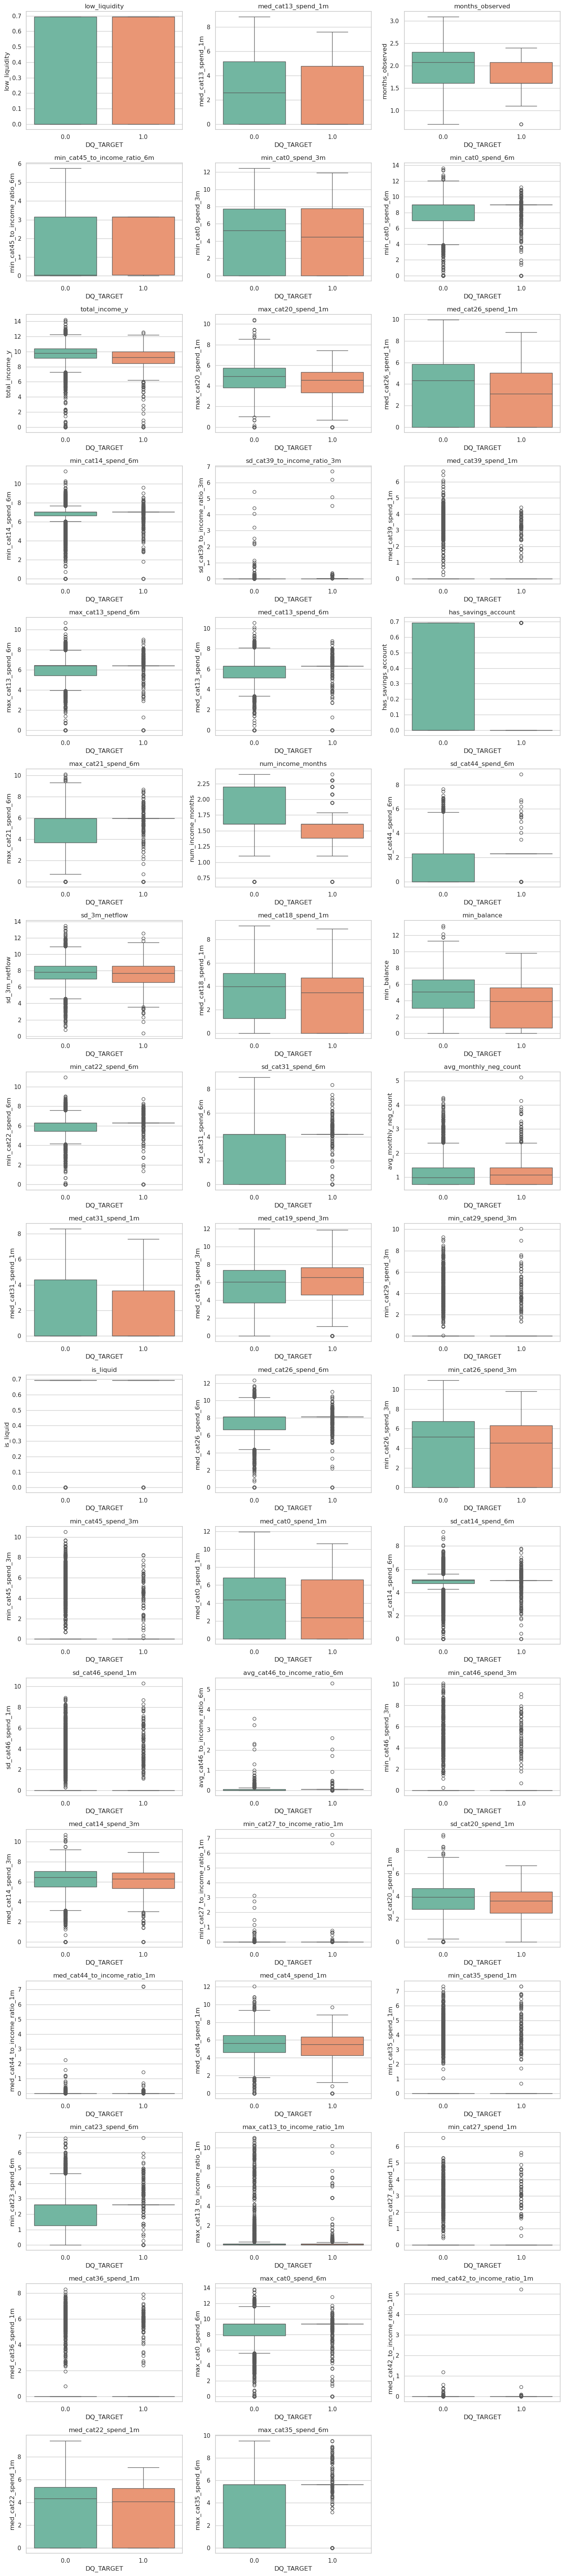

In [223]:
import seaborn as sns
feature_cols = top_50_features
X_log = np.log1p(all_feats[feature_cols].clip(lower=0))
# Keep the target
X_log[TARGET] = all_feats[TARGET]
sns.set(style="whitegrid")
n_cols = 3
n_rows = int(np.ceil(len(top_50_features)/n_cols))

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, feat in enumerate(top_50_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(
        x=TARGET, 
        y=feat, 
        data=X_log,
        palette="Set2"
    )
    plt.title(feat)
    plt.xlabel("DQ_TARGET")
    plt.ylabel(feat)

plt.tight_layout()
plt.show()